In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd
import json
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

In [4]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'

In [5]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:35<00:00,  2.99it/s]


In [9]:
dx = [i[0] for i in nets]

In [10]:
borough_df = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-borough.geojson'))

In [11]:
poi_df = pd.read_csv(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-POI-INFO.csv'))
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.longitude, poi_df.latitude))

In [49]:
merged = gpd.sjoin(gdf, borough_df, how='left', op='within')

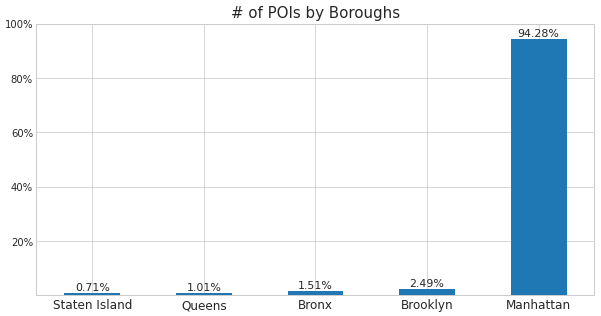

In [72]:
with plt.style.context('seaborn-whitegrid'):
    s = merged.groupby('boro_name').size().sort_values()
    s /= s.sum()
    ax = s.plot.bar(rot=0, figsize=(10, 5))
    for i, v in enumerate(s.values):
        ax.text(i, v+0.01, f'{v*100:.2f}%', horizontalalignment='center', fontsize=11)
    ax.set_title('# of POIs by Boroughs', fontsize=15)
    ax.set_xlabel(None)
    #ax.set_ylim(0, s.max()+2700)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.savefig('pois-by-boroughs-percentage.png')

In [14]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [15]:
area_cbgs = get_CBGS(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)
census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

fp2name = {
    '081': 'Queens',
    '005': 'Bronx',
    '085': 'Staten Island',
    '061': 'Manhattan',
    '047': 'Brooklyn' 
}

census_attrs['borough'] = census_attrs['census_block_group'].apply(lambda x: fp2name[str(x)[2:5]])

commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
quart = ['Bottom', 'Third', 'Second', 'Top']
for col in col_names:
    census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

census_quartiles = census_attrs[['census_block_group', 'borough', *[f'{cn}-quartile' for cn in col_names]]]
census_raw_values = census_attrs[['census_block_group', 'borough', *col_names]]

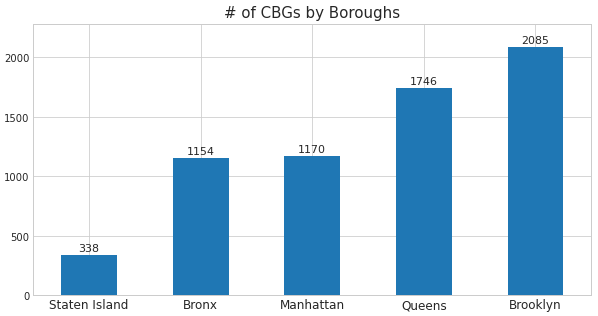

In [44]:
with plt.style.context('seaborn-whitegrid'):
    s = census_quartiles.groupby('borough').size().sort_values()
    ax = s.plot.bar(rot=0, figsize=(10, 5))
    for i, v in enumerate(s.values):
        ax.text(i, v+30, str(v), horizontalalignment='center', fontsize=11)
    ax.set_title('# of CBGs by Boroughs', fontsize=15)
    ax.set_xlabel(None)
    ax.set_ylim(0, s.max()+200)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.savefig('cbgs-by-boroughs.png')

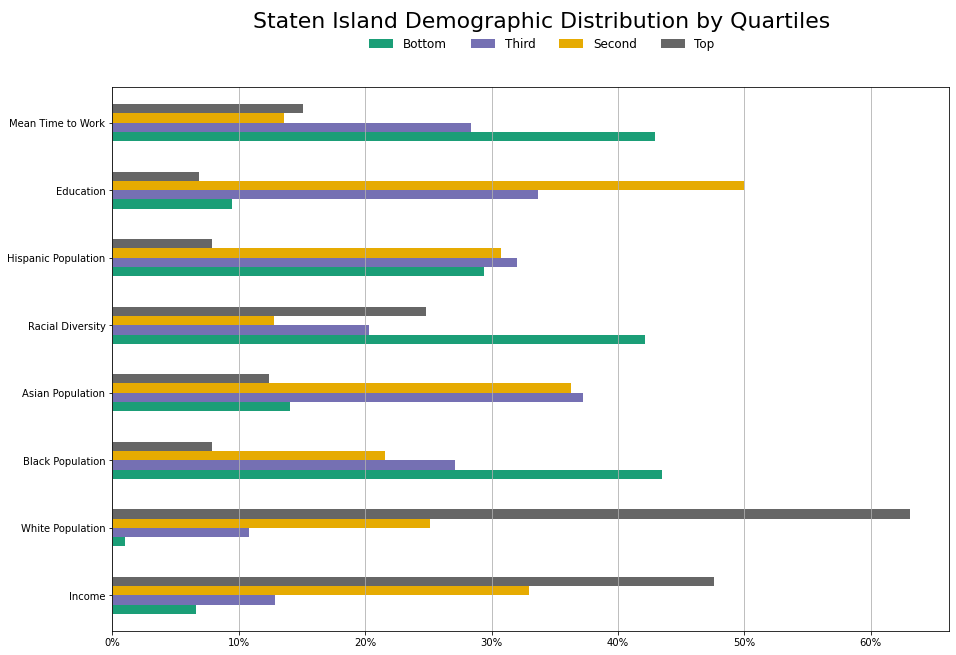

In [67]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
s = census_quartiles[census_quartiles['borough'] == 'Staten Island'][[f'{cn}-quartile' for cn in col_names]]
s.columns = ['Income', 'White Population', 'Black Population', 'Asian Population', 'Racial Diversity', 'Hispanic Population', 'Education', 'Mean Time to Work']
s.apply(pd.Series.value_counts, normalize=True).T.plot.barh(ax=ax, legend=None, width=0.55, cmap='Dark2')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.grid(axis='x')
fig.legend(ncol=4, 
           title='Staten Island Demographic Distribution by Quartiles', 
           title_fontsize=22,
           fontsize=12,
           bbox_to_anchor=(0.8, 1),
           edgecolor='white'
          )

fig.savefig('staten_island_demo.png', bbox_inches='tight')

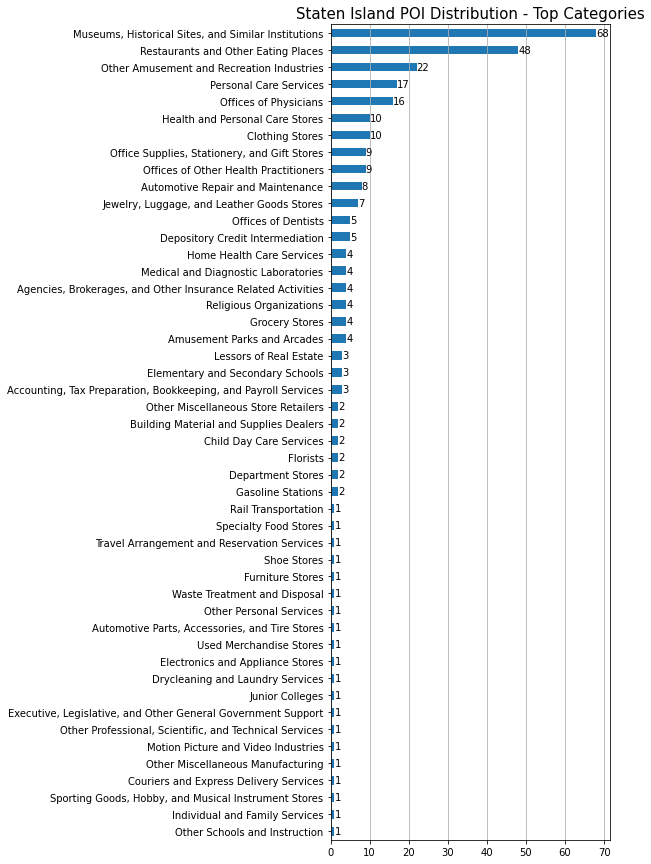

In [7]:
sl_poi = merged[merged['boro_name'] == 'Staten Island']['top_category'].value_counts(normalize=False)[::-1]
ax = sl_poi.plot.barh(figsize=(5, 15))
ax.grid(axis='x')
#ax.set_xlim(0, 75)
ax.set_title('Staten Island POI Distribution - Top Categories', fontsize=15)

for i, val in enumerate(sl_poi):
    ax.text(val, i, str(val), verticalalignment='center')
    
#plt.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, 'nyc-staten-island-poi-dist-topcat.png'), bbox_inches='tight')

In [8]:
PATTERN_DIR = join(pwd, dpath, 'filtered-patterns')

AREA_NAME = 'NYC'
FILTERED_PATTERN_DIR = join(PATTERN_DIR, f'{AREA_NAME}-patterns')
pattern_files = [join(FILTERED_PATTERN_DIR, f) for f in os.listdir(FILTERED_PATTERN_DIR) if f.endswith('csv')]

In [9]:
sl_cbgs = set(pd.read_csv(join(pwd, 'util_datasets', 'staten_island_cbgs.csv'))['cbgs'].astype(np.int64).values)

In [14]:
def check_cbg(visitor_cbgs):
    for cbg in json.loads(visitor_cbgs).keys():
        cbg = np.int64(cbg)
        if cbg in sl_cbgs:
            return True
    return False

def get_visits(cbgs):
    c = 0
    d = json.loads(cbgs)
    for cbg in d.keys():
        icbg = np.int64(cbg)
        if icbg in sl_cbgs:
            c += d[cbg]
    return c

In [16]:
cat_df = poi_df[['safegraph_place_id', 'top_category', 'sub_category']].set_index('safegraph_place_id')

In [20]:
c2n = dict(zip(poi_df['safegraph_place_id'], poi_df['top_category']))

In [96]:
sg_ids = []
for pattern_file in tqdm(pattern_files):
    df = pd.read_csv(pattern_file)
    sl_ind = df['poi_cbg'].isin(sl_cbgs)
    sl_df = df[sl_ind]
    other_df = df[~sl_ind]
    
    other_df = other_df.merge(poi_df[['safegraph_place_id', 'top_category', 'sub_category']], on='safegraph_place_id', how='inner')
    
    sdf = other_df[other_df['visitor_home_cbgs'].apply(check_cbg)]
    sdf['count'] = sdf['visitor_home_cbgs'].apply(get_visits)
    sg_ids.append(sdf[['top_category', 'sub_category', 'count']])

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [01:04<00:00,  1.65it/s]


In [195]:
ex = ['Museums, Historical Sites, and Similar Institutions', 'Other Amusement and Recreation Industries', 'Restaurants and Other Eating Places']
ll = []

for sg in sg_ids:
    sg = sg.dropna()
    sg = sg[~sg['top_category'].isin(ex)]
    topn = sg.groupby('sub_category').sum()['count'].sort_values(ascending=False) / sg['count'].sum()
    ll += list(topn[:10].index)
    
el = [i[0] for i in Counter(ll).most_common(5)]

In [196]:
rows = []
for sg in sg_ids:
    sg = sg.dropna()
    sg = sg[~sg['top_category'].isin(ex)]
    topn = sg.groupby('sub_category').sum()['count']/ sg['count'].sum()
    rows.append(topn[el])

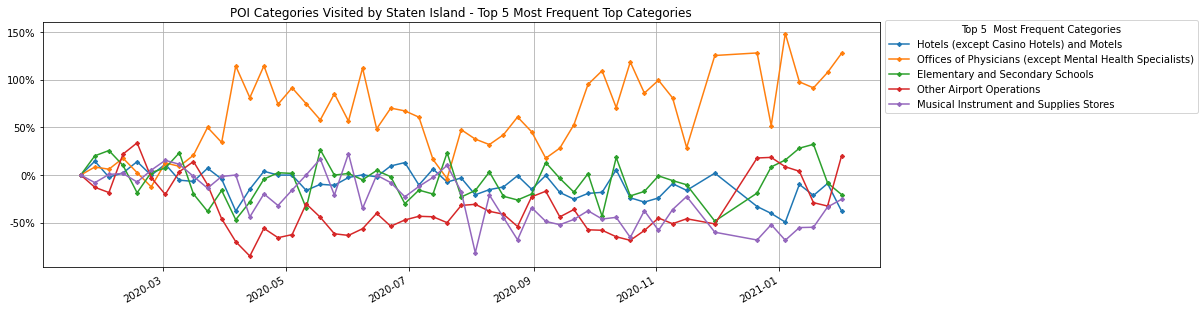

In [199]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

t = datetime(2020, 1, 20)

pdf = pd.concat(rows, axis=1).T
pdf.index = dx
pdf = pdf.loc[t:]
pdf = pdf.div(pdf.iloc[0], axis=1)
pdf.plot(ax=ax, marker='D', markersize=3)
ax.legend(bbox_to_anchor=(1, 1.03), ncol=1, title='Top 5  Most Frequent Categories')
ax.set_title('POI Categories Visited by Staten Island - Top 5 Most Frequent Top Categories')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{(y-1)*100:.0f}%'))
ax.grid()

fig.savefig(join(FIG_SAVE_DIR, 'nyc-staten-island-outflow-categories-top5-sel-SUB-rel-chg.png'), bbox_inches='tight')